# Balanced Dataset Preparation for Regime Classification

**Objective**: Address class imbalance in regime classification while preserving time-series integrity.

**Problems to Solve**:
1. Dataset imbalance (79% class 0 vs 21% class 1)
2. Proper feature standardization without future data leakage
3. Enhanced relational features (crossovers, divergences)

**Approach**:
1. Load and analyze raw feature data
2. Engineer new relational features
3. Apply appropriate standardization (only to bounded/relative features)
4. Handle class imbalance using time-series aware techniques
5. Export balanced dataset for model training

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

# Set Project Root
project_root = Path('..').resolve()

# Load Data
data_path = project_root / 'data' / 'BTCUSDT_2021_2023_1m_features.csv'
print(f"Loading data from {data_path}...")
df = pd.read_csv(data_path, parse_dates=['timestamp'], index_col='timestamp')
print(f"Data Shape: {df.shape}")
print(f"Date Range: {df.index.min()} to {df.index.max()}")

Loading data from E:\Coding\Crypto_Research\data\BTCUSDT_2021_2023_1m_features.csv...
Data Shape: (1534847, 42)
Date Range: 2021-01-01 00:00:00 to 2023-12-31 14:27:00


## 1. Feature Engineering: Relational Features

Create features that capture relationships between indicators:

In [17]:
print("Engineering relational features...")

# 1. Price Distance from MAs (Normalized by price - no leakage)
df['price_dist_sma7_pct'] = (df['Close'] - df['sma_7d']) / df['Close']
df['price_dist_sma30_pct'] = (df['Close'] - df['sma_30d']) / df['Close']
df['price_dist_ema7_pct'] = (df['Close'] - df['ema_7d']) / df['Close']
df['price_dist_ema21_pct'] = (df['Close'] - df['ema_21d']) / df['Close']

# 2. EMA/SMA Crossovers (Trend direction)
df['ema7_above_sma7'] = (df['ema_7d'] > df['sma_7d']).astype(int)
df['ema21_above_sma30'] = (df['ema_21d'] > df['sma_30d']).astype(int)

# 3. EMA/SMA Crossover Direction (Detects recent crosses)
# If EMA was below SMA and now above = 1 (bullish cross)
# If EMA was above SMA and now below = -1 (bearish cross)
# Otherwise = 0 (no change)
df['ema7_sma7_prev'] = (df['ema_7d'].shift(1) > df['sma_7d'].shift(1)).astype(int)
df['ema7_sma7_cross'] = 0
df.loc[(df['ema7_above_sma7'] == 1) & (df['ema7_sma7_prev'] == 0), 'ema7_sma7_cross'] = 1  # Bullish
df.loc[(df['ema7_above_sma7'] == 0) & (df['ema7_sma7_prev'] == 1), 'ema7_sma7_cross'] = -1  # Bearish

# 4. Bollinger Band Position (0-1 scale)
df['bb_position'] = (df['Close'] - df['bb_lower_20d']) / (df['bb_upper_20d'] - df['bb_lower_20d'])
df['bb_position'] = df['bb_position'].clip(0, 1)  # Keep within bounds

# 5. MACD Signal Crossover
df['macd_above_signal'] = (df['macd'] > df['macd_signal']).astype(int)
df['macd_signal_prev'] = (df['macd'].shift(1) > df['macd_signal'].shift(1)).astype(int)
df['macd_cross'] = 0
df.loc[(df['macd_above_signal'] == 1) & (df['macd_signal_prev'] == 0), 'macd_cross'] = 1  # Bullish
df.loc[(df['macd_above_signal'] == 0) & (df['macd_signal_prev'] == 1), 'macd_cross'] = -1  # Bearish

# 6. RSI Regime Changes
df['rsi_oversold'] = (df['rsi_14d'] < 30).astype(int)
df['rsi_overbought'] = (df['rsi_14d'] > 70).astype(int)
df['rsi_neutral'] = ((df['rsi_14d'] >= 30) & (df['rsi_14d'] <= 70)).astype(int)

# 7. Momentum: Price change over different windows (Stationary)
df['price_change_1h'] = df['Close'].pct_change(60)  # 60 minutes
df['price_change_4h'] = df['Close'].pct_change(240)  # 4 hours
df['price_change_1d'] = df['Close'].pct_change(1440)  # 1 day

# 8. Volume Momentum (Normalized)
df['volume_ma_7d'] = df['Volume'].rolling(window=7*1440).mean()
df['volume_ratio'] = df['Volume'] / df['volume_ma_7d']

# 9. Volatility-adjusted ATR (Normalized by price)
df['atr_normalized'] = df['atr_14d'] / df['Close']

# 10. Trend Strength: ADX with direction
# ADX > 25 indicates strong trend
df['strong_trend'] = (df['adx_14d'] > 25).astype(int)

# 11. MA Slope (Direction of trend)
df['sma7_slope'] = df['sma_7d'].diff(1440) / df['sma_7d']  # Daily change rate
df['sma30_slope'] = df['sma_30d'].diff(1440) / df['sma_30d']

print(f"New features created. Current shape: {df.shape}")
print("\nNew feature columns:")
new_features = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 
                'sma_7d', 'sma_30d', 'sma_90d', 'ema_7d', 'ema_21d', 'adx_14d', 'rsi_14d', 'rsi_30d',
                'stoch_k_14d', 'stoch_d_14d', 'macd', 'macd_signal', 'macd_diff', 'rsi_14d_q70', 'rsi_14d_q30',
                'rsi_14d_regime', 'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d', 'atr_14d',
                'trend_sma_1d', 'residual_ratio_1d', 'residual_diff_1d', 'trend_sma_7d', 'residual_ratio_7d',
                'residual_diff_7d', 'trend_sma_30d', 'residual_ratio_30d', 'residual_diff_30d',
                'log_ret', 'volatility_7d', 'volatility_mean_7d', 'volatility_ratio_7d',
                'volatility_30d', 'volatility_mean_30d', 'volatility_ratio_30d', 'fd_7d']]
print(new_features)

Engineering relational features...
New features created. Current shape: (1534847, 66)

New feature columns:
['price_dist_sma7_pct', 'price_dist_sma30_pct', 'price_dist_ema7_pct', 'price_dist_ema21_pct', 'ema7_above_sma7', 'ema21_above_sma30', 'ema7_sma7_prev', 'ema7_sma7_cross', 'bb_position', 'macd_above_signal', 'macd_signal_prev', 'macd_cross', 'rsi_oversold', 'rsi_overbought', 'rsi_neutral', 'price_change_1h', 'price_change_4h', 'price_change_1d', 'volume_ma_7d', 'volume_ratio', 'atr_normalized', 'strong_trend', 'sma7_slope', 'sma30_slope']


## 2. Define Target

Define bullish regime: price increases by threshold within lookahead window

In [18]:
# Define Target using original 1-minute data
print("Defining target variable...")

# Define Target: 2% return in next 24 hours (1440 minutes)
LOOKAHEAD_MINUTES = 1440  # 24 hours
THRESHOLD = 0.02

df['Future_Return'] = df['Close'].shift(-LOOKAHEAD_MINUTES) / df['Close'] - 1
df['Target'] = (df['Future_Return'] > THRESHOLD).astype(int)

# Remove rows with NaN target
df_clean = df[df['Target'].notna()].copy()

print(f"Clean Data Shape: {df_clean.shape}")
print(f"\nTarget Distribution (Original):")
print(df_clean['Target'].value_counts(normalize=True))
print(f"\nAbsolute counts:")
print(df_clean['Target'].value_counts())

Defining target variable...
Clean Data Shape: (1534847, 68)

Target Distribution (Original):
Target
0    0.782669
1    0.217331
Name: proportion, dtype: float64

Absolute counts:
Target
0    1201277
1     333570
Name: count, dtype: int64


## 3. Feature Standardization (Only Safe Features)

Standardize features that:
- Are already bounded (RSI, Stochastic, ADX)
- Are relative/ratio metrics (returns, ratios, differences)
- Don't contain absolute price/volume information

**DO NOT standardize**:
- Raw prices (Close, Open, High, Low)
- Moving averages (SMA, EMA)
- Bollinger Bands
- ATR (absolute)
- Volume (absolute)

In [19]:
# Features that CAN be standardized (no future leakage)
features_to_standardize = [
    # Bounded indicators (0-100 or 0-1)
    'rsi_14d', 'rsi_30d',
    'stoch_k_14d', 'stoch_d_14d',
    'adx_14d',
    
    # Relative metrics (ratios, differences, returns)
    'macd', 'macd_signal', 'macd_diff',
    'residual_ratio_1d', 'residual_diff_1d',
    'residual_ratio_7d', 'residual_diff_7d',
    'residual_ratio_30d', 'residual_diff_30d',
    'log_ret',
    'volatility_ratio_7d', 'volatility_ratio_30d',
    'fd_7d',
    
    # New relational features (already normalized or relative)
    'price_dist_sma7_pct', 'price_dist_sma30_pct',
    'price_dist_ema7_pct', 'price_dist_ema21_pct',
    'bb_position',
    'price_change_1h', 'price_change_4h', 'price_change_1d',
    'volume_ratio',
    'atr_normalized',
    'sma7_slope', 'sma30_slope'
]

# Features that should NOT be standardized (absolute values)
features_no_standardization = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'sma_7d', 'sma_30d', 'sma_90d',
    'ema_7d', 'ema_21d',
    'bb_mid_20d', 'bb_upper_20d', 'bb_lower_20d',
    'atr_14d',
    'trend_sma_1d', 'trend_sma_7d', 'trend_sma_30d',
    'volatility_7d', 'volatility_30d',
    'volatility_mean_7d', 'volatility_mean_30d',
    'volume_ma_7d'
]

# Categorical/Binary features (no standardization needed)
categorical_features = [
    'rsi_14d_regime',
    'ema7_above_sma7', 'ema21_above_sma30',
    'ema7_sma7_cross', 'macd_cross',
    'macd_above_signal',
    'rsi_oversold', 'rsi_overbought', 'rsi_neutral',
    'strong_trend'
]

print(f"Features to standardize: {len(features_to_standardize)}")
print(f"Features without standardization: {len(features_no_standardization)}")
print(f"Categorical features: {len(categorical_features)}")

# Check which features exist in df_clean
features_to_standardize = [f for f in features_to_standardize if f in df_clean.columns]
print(f"\nActual features to standardize (exist in data): {len(features_to_standardize)}")

Features to standardize: 30
Features without standardization: 22
Categorical features: 10

Actual features to standardize (exist in data): 30


In [20]:
# Create a copy for standardization
df_processed = df_clean.copy()

# Use RobustScaler (less sensitive to outliers than StandardScaler)
scaler = RobustScaler()

# Only standardize if features exist
if features_to_standardize:
    df_processed[features_to_standardize] = scaler.fit_transform(df_processed[features_to_standardize])
    print("Standardization complete.")
else:
    print("No features to standardize.")

print(f"\nProcessed data shape: {df_processed.shape}")

Standardization complete.

Processed data shape: (1534847, 68)


In [21]:
# Save a full dataset with engineered features and standardized values
output_path = project_root / 'data' / 'BTCUSDT_2021_2023_1m_features_standardized.csv'

# Drop helper columns that are not needed for modeling
exclude_cols = [
    'Future_Return', 'Target',  # Target-related
    'ema7_sma7_prev', 'macd_signal_prev',  # Helper columns
    'rsi_14d_q70', 'rsi_14d_q30',  # Quantiles (already have regime)
    'volume_ma_7d'  # Helper for volume_ratio
]

df_saved = df_processed.drop(columns=exclude_cols, errors='ignore')
print(f"Final dataset shape to save: {df_saved.shape}")

df_saved.to_csv(output_path)
print(f"Processed dataset saved to {output_path}")

Final dataset shape to save: (1534847, 61)
Processed dataset saved to E:\Coding\Crypto_Research\data\BTCUSDT_2021_2023_1m_features_standardized.csv


## 4. Prepare Feature Matrix

Select features for modeling (exclude raw OHLCV and helper columns):

In [8]:
# Exclude columns that shouldn't be used as features
exclude_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',  # Raw OHLCV
    'Future_Return', 'Target',  # Target-related
    'ema7_sma7_prev', 'macd_signal_prev',  # Helper columns
    'rsi_14d_q70', 'rsi_14d_q30',  # Quantiles (already have regime)
    'volume_ma_7d'  # Helper for volume_ratio
]

# Get all feature columns
feature_cols = [col for col in df_processed.columns if col not in exclude_cols]

print(f"Total feature columns: {len(feature_cols)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Create feature matrix and target
X = df_processed[feature_cols].copy()
y = df_processed['Target'].copy()

# Remove any remaining NaN
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print(f"\nFinal X shape: {X.shape}")
print(f"Final y shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts(normalize=True))

Total feature columns: 56

Feature list:
 1. sma_7d
 2. sma_30d
 3. sma_90d
 4. ema_7d
 5. ema_21d
 6. adx_14d
 7. rsi_14d
 8. rsi_30d
 9. stoch_k_14d
10. stoch_d_14d
11. macd
12. macd_signal
13. macd_diff
14. rsi_14d_regime
15. bb_mid_20d
16. bb_upper_20d
17. bb_lower_20d
18. atr_14d
19. trend_sma_1d
20. residual_ratio_1d
21. residual_diff_1d
22. trend_sma_7d
23. residual_ratio_7d
24. residual_diff_7d
25. trend_sma_30d
26. residual_ratio_30d
27. residual_diff_30d
28. log_ret
29. volatility_7d
30. volatility_mean_7d
31. volatility_ratio_7d
32. volatility_30d
33. volatility_mean_30d
34. volatility_ratio_30d
35. fd_7d
36. price_dist_sma7_pct
37. price_dist_sma30_pct
38. price_dist_ema7_pct
39. price_dist_ema21_pct
40. ema7_above_sma7
41. ema21_above_sma30
42. ema7_sma7_cross
43. bb_position
44. macd_above_signal
45. macd_cross
46. rsi_oversold
47. rsi_overbought
48. rsi_neutral
49. price_change_1h
50. price_change_4h
51. price_change_1d
52. volume_ratio
53. atr_normalized
54. strong_tren

## 5. Handle Class Imbalance

### Strategy 1: Time-Aware Undersampling

Randomly undersample majority class while maintaining temporal order:

In [9]:
from collections import Counter

# Get indices for each class
class_0_idx = y[y == 0].index
class_1_idx = y[y == 1].index

print(f"Class 0 samples: {len(class_0_idx)}")
print(f"Class 1 samples: {len(class_1_idx)}")

# Strategy 1: Random Undersampling (1:1 ratio)
np.random.seed(42)
class_0_undersampled = np.random.choice(class_0_idx, size=len(class_1_idx), replace=False)
balanced_idx_1to1 = np.concatenate([class_0_undersampled, class_1_idx])
balanced_idx_1to1 = np.sort(balanced_idx_1to1)  # Maintain temporal order

X_balanced_1to1 = X.loc[balanced_idx_1to1]
y_balanced_1to1 = y.loc[balanced_idx_1to1]

print(f"\nBalanced 1:1 Dataset:")
print(f"Shape: {X_balanced_1to1.shape}")
print(f"Target distribution:")
print(y_balanced_1to1.value_counts(normalize=True))

# Strategy 2: Moderate Undersampling (2:1 ratio)
class_0_undersampled_2to1 = np.random.choice(class_0_idx, size=len(class_1_idx)*2, replace=False)
balanced_idx_2to1 = np.concatenate([class_0_undersampled_2to1, class_1_idx])
balanced_idx_2to1 = np.sort(balanced_idx_2to1)

X_balanced_2to1 = X.loc[balanced_idx_2to1]
y_balanced_2to1 = y.loc[balanced_idx_2to1]

print(f"\nBalanced 2:1 Dataset:")
print(f"Shape: {X_balanced_2to1.shape}")
print(f"Target distribution:")
print(y_balanced_2to1.value_counts(normalize=True))

Class 0 samples: 1058371
Class 1 samples: 260477

Balanced 1:1 Dataset:
Shape: (520954, 56)
Target distribution:
Target
0    0.5
1    0.5
Name: proportion, dtype: float64

Balanced 2:1 Dataset:
Shape: (781431, 56)
Target distribution:
Target
0    0.666667
1    0.333333
Name: proportion, dtype: float64


### Strategy 2: SMOTE with Careful Application

Generate synthetic samples for minority class. 
**Note**: SMOTE can be risky for time-series, so we'll apply it carefully and create a separate dataset for comparison.

In [10]:
# Apply SMOTE to create synthetic minority samples
# We'll use a moderate sampling strategy (not full 1:1)

print("Applying SMOTE...")
smote = SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)  # Bring minority to 50% of majority

try:
    X_smote, y_smote = smote.fit_resample(X, y)
    print(f"\nSMOTE Dataset:")
    print(f"Shape: {X_smote.shape}")
    print(f"Target distribution:")
    print(Counter(y_smote))
    print(f"Proportion: {Counter(y_smote)[1] / len(y_smote):.3f} minority class")
    
    # Convert back to DataFrame for consistency
    X_smote = pd.DataFrame(X_smote, columns=X.columns)
    y_smote = pd.Series(y_smote, name='Target')
    
except Exception as e:
    print(f"SMOTE failed: {e}")
    X_smote, y_smote = None, None

Applying SMOTE...

SMOTE Dataset:
Shape: (1587556, 56)
Target distribution:
Counter({0: 1058371, 1: 529185})
Proportion: 0.333 minority class


### Strategy 3: Combined SMOTE + Tomek Links

Oversample minority class with SMOTE, then clean overlapping samples with Tomek Links:

In [11]:
print("Applying SMOTETomek...")
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)

try:
    X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X, y)
    print(f"\nSMOTETomek Dataset:")
    print(f"Shape: {X_smote_tomek.shape}")
    print(f"Target distribution:")
    print(Counter(y_smote_tomek))
    print(f"Proportion: {Counter(y_smote_tomek)[1] / len(y_smote_tomek):.3f} minority class")
    
    # Convert back to DataFrame
    X_smote_tomek = pd.DataFrame(X_smote_tomek, columns=X.columns)
    y_smote_tomek = pd.Series(y_smote_tomek, name='Target')
    
except Exception as e:
    print(f"SMOTETomek failed: {e}")
    X_smote_tomek, y_smote_tomek = None, None

Applying SMOTETomek...

SMOTETomek Dataset:
Shape: (1583880, 56)
Target distribution:
Counter({0: 1056533, 1: 527347})
Proportion: 0.333 minority class


## 6. Export Datasets

Save multiple versions for experimentation:

In [12]:
# Create output directory
output_dir = project_root / 'data' / 'balanced_datasets'
output_dir.mkdir(exist_ok=True)

print(f"Saving datasets to {output_dir}...\n")

# 1. Original (with new features, standardized)
df_original = pd.concat([X, y], axis=1)
output_path = output_dir / 'regime_classification_original_enhanced.csv'
df_original.to_csv(output_path)
print(f"1. Original enhanced: {output_path.name} ({df_original.shape})")

# 2. Balanced 1:1 (Random Undersampling)
df_balanced_1to1 = pd.concat([X_balanced_1to1, y_balanced_1to1], axis=1)
output_path = output_dir / 'regime_classification_balanced_1to1.csv'
df_balanced_1to1.to_csv(output_path)
print(f"2. Balanced 1:1: {output_path.name} ({df_balanced_1to1.shape})")

# 3. Balanced 2:1 (Moderate Undersampling)
df_balanced_2to1 = pd.concat([X_balanced_2to1, y_balanced_2to1], axis=1)
output_path = output_dir / 'regime_classification_balanced_2to1.csv'
df_balanced_2to1.to_csv(output_path)
print(f"3. Balanced 2:1: {output_path.name} ({df_balanced_2to1.shape})")

# 4. SMOTE (if successful)
if X_smote is not None:
    df_smote = pd.concat([X_smote, y_smote], axis=1)
    output_path = output_dir / 'regime_classification_smote.csv'
    df_smote.to_csv(output_path, index=False)
    print(f"4. SMOTE: {output_path.name} ({df_smote.shape})")

# 5. SMOTE + Tomek (if successful)
if X_smote_tomek is not None:
    df_smote_tomek = pd.concat([X_smote_tomek, y_smote_tomek], axis=1)
    output_path = output_dir / 'regime_classification_smote_tomek.csv'
    df_smote_tomek.to_csv(output_path, index=False)
    print(f"5. SMOTE+Tomek: {output_path.name} ({df_smote_tomek.shape})")

print("\nAll datasets saved successfully!")

Saving datasets to E:\Coding\Crypto_Research\data\balanced_datasets...

1. Original enhanced: regime_classification_original_enhanced.csv ((1318848, 57))
2. Balanced 1:1: regime_classification_balanced_1to1.csv ((520954, 57))
3. Balanced 2:1: regime_classification_balanced_2to1.csv ((781431, 57))
4. SMOTE: regime_classification_smote.csv ((1587556, 57))
5. SMOTE+Tomek: regime_classification_smote_tomek.csv ((1583880, 57))

All datasets saved successfully!


## 7. Visualization: Feature Distributions

Compare feature distributions across different balancing strategies:

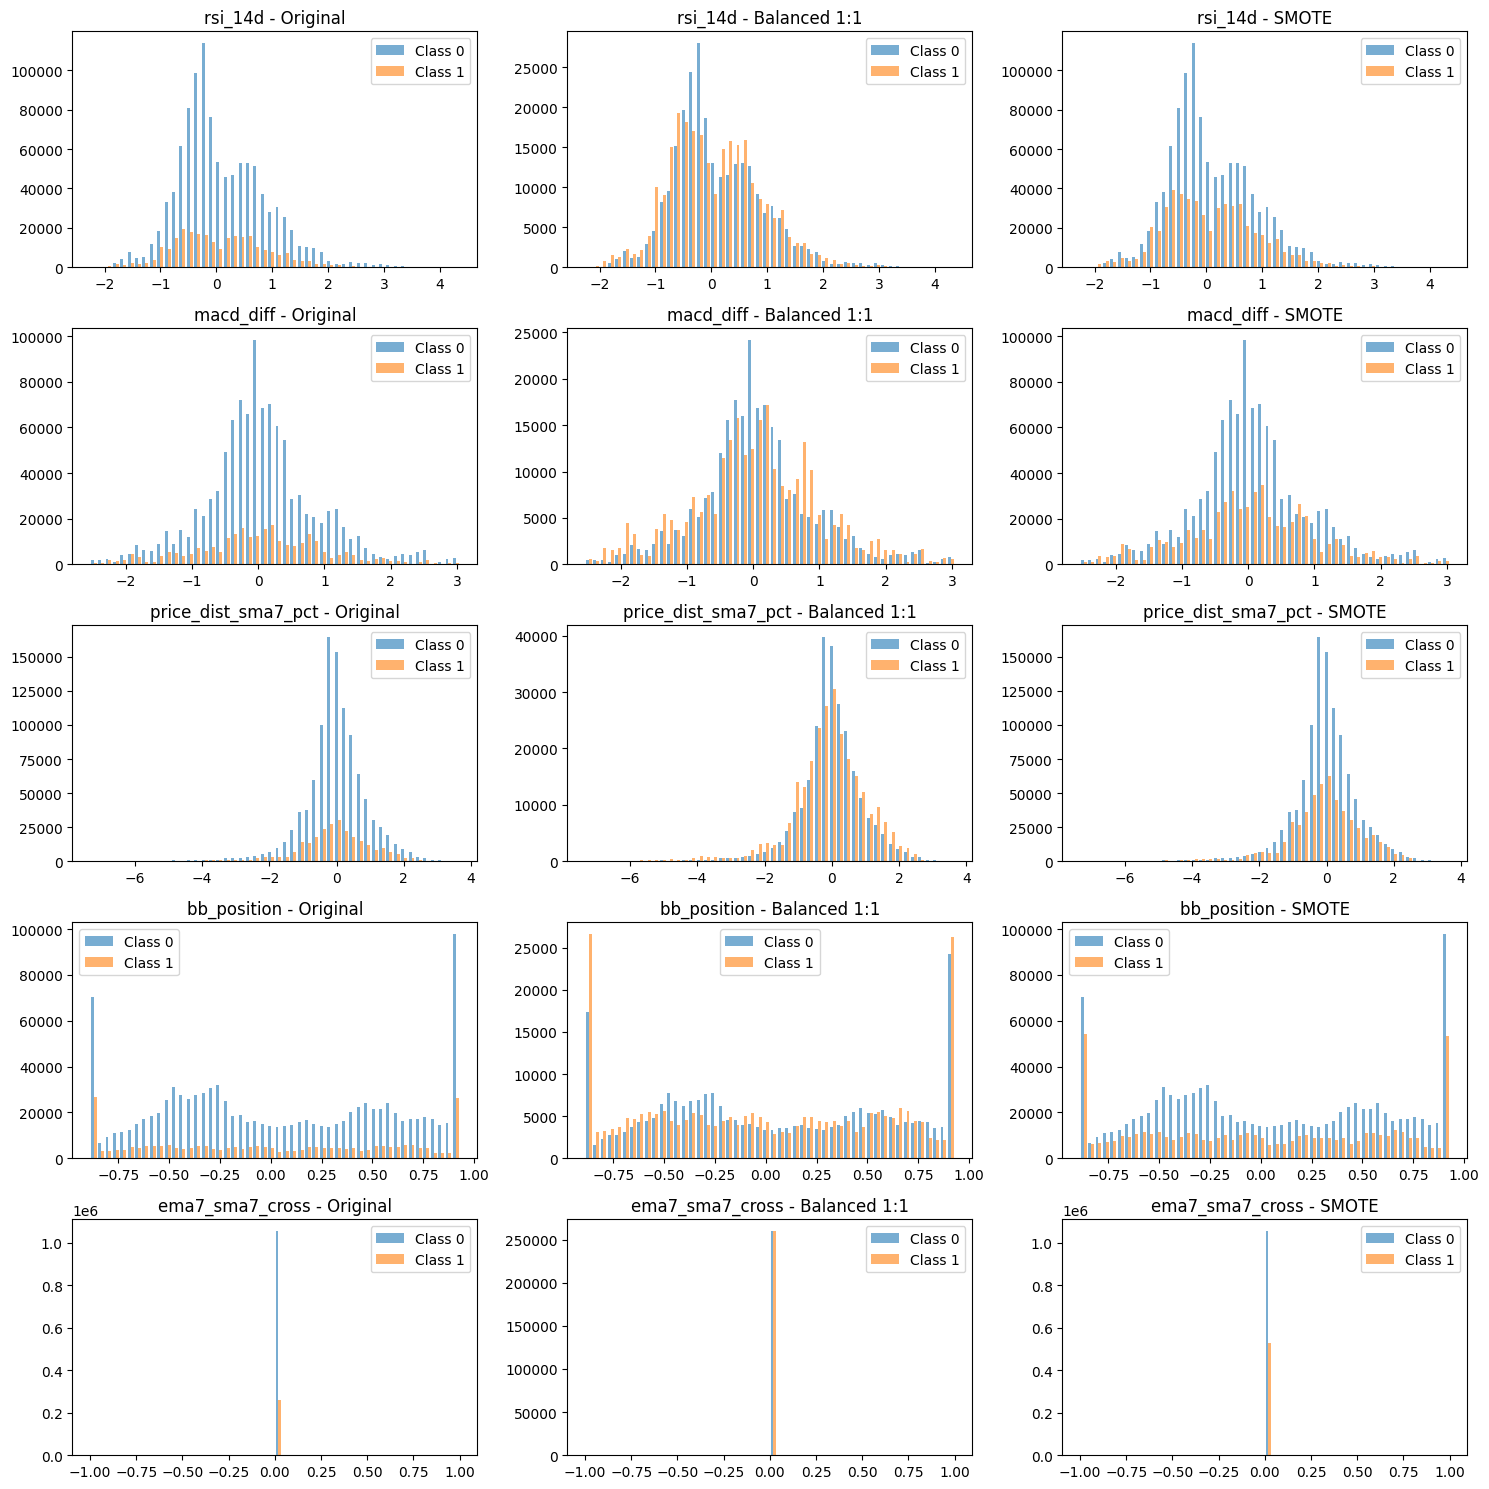

Feature distribution plot saved to E:\Coding\Crypto_Research\data\balanced_datasets\feature_distributions_comparison.png


In [13]:
# Select a few key features to visualize
key_features = ['rsi_14d', 'macd_diff', 'price_dist_sma7_pct', 'bb_position', 'ema7_sma7_cross']
key_features = [f for f in key_features if f in X.columns]

fig, axes = plt.subplots(len(key_features), 3, figsize=(15, 3*len(key_features)))

for i, feature in enumerate(key_features):
    # Original
    axes[i, 0].hist([X[feature][y==0], X[feature][y==1]], bins=50, alpha=0.6, label=['Class 0', 'Class 1'])
    axes[i, 0].set_title(f'{feature} - Original')
    axes[i, 0].legend()
    
    # Balanced 1:1
    axes[i, 1].hist([X_balanced_1to1[feature][y_balanced_1to1==0], 
                      X_balanced_1to1[feature][y_balanced_1to1==1]], 
                     bins=50, alpha=0.6, label=['Class 0', 'Class 1'])
    axes[i, 1].set_title(f'{feature} - Balanced 1:1')
    axes[i, 1].legend()
    
    # SMOTE (if available)
    if X_smote is not None:
        axes[i, 2].hist([X_smote[feature][y_smote==0], 
                          X_smote[feature][y_smote==1]], 
                         bins=50, alpha=0.6, label=['Class 0', 'Class 1'])
        axes[i, 2].set_title(f'{feature} - SMOTE')
        axes[i, 2].legend()
    else:
        axes[i, 2].text(0.5, 0.5, 'SMOTE not available', ha='center', va='center')
        axes[i, 2].set_title(f'{feature} - SMOTE')

plt.tight_layout()
plt.savefig(output_dir / 'feature_distributions_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Feature distribution plot saved to {output_dir / 'feature_distributions_comparison.png'}")

## 8. Summary Report

In [14]:
print("="*80)
print("BALANCED DATASET PREPARATION SUMMARY")
print("="*80)

print("\n1. FEATURE ENGINEERING")
print(f"   - Total features: {len(feature_cols)}")
print(f"   - Relational features: {len(new_features)}")
print(f"   - Standardized features: {len(features_to_standardize)}")
print(f"   - Non-standardized features: {len(features_no_standardization)}")
print(f"   - Categorical features: {len(categorical_features)}")

print("\n2. DATASET VERSIONS")
print(f"   a) Original Enhanced: {X.shape[0]} samples, {X.shape[1]} features")
print(f"      Class 0: {(y==0).sum()} ({(y==0).sum()/len(y)*100:.1f}%)")
print(f"      Class 1: {(y==1).sum()} ({(y==1).sum()/len(y)*100:.1f}%)")

print(f"\n   b) Balanced 1:1: {X_balanced_1to1.shape[0]} samples, {X_balanced_1to1.shape[1]} features")
print(f"      Class 0: {(y_balanced_1to1==0).sum()} ({(y_balanced_1to1==0).sum()/len(y_balanced_1to1)*100:.1f}%)")
print(f"      Class 1: {(y_balanced_1to1==1).sum()} ({(y_balanced_1to1==1).sum()/len(y_balanced_1to1)*100:.1f}%)")

print(f"\n   c) Balanced 2:1: {X_balanced_2to1.shape[0]} samples, {X_balanced_2to1.shape[1]} features")
print(f"      Class 0: {(y_balanced_2to1==0).sum()} ({(y_balanced_2to1==0).sum()/len(y_balanced_2to1)*100:.1f}%)")
print(f"      Class 1: {(y_balanced_2to1==1).sum()} ({(y_balanced_2to1==1).sum()/len(y_balanced_2to1)*100:.1f}%)")

if X_smote is not None:
    print(f"\n   d) SMOTE: {X_smote.shape[0]} samples, {X_smote.shape[1]} features")
    print(f"      Class 0: {(y_smote==0).sum()} ({(y_smote==0).sum()/len(y_smote)*100:.1f}%)")
    print(f"      Class 1: {(y_smote==1).sum()} ({(y_smote==1).sum()/len(y_smote)*100:.1f}%)")

if X_smote_tomek is not None:
    print(f"\n   e) SMOTE+Tomek: {X_smote_tomek.shape[0]} samples, {X_smote_tomek.shape[1]} features")
    print(f"      Class 0: {(y_smote_tomek==0).sum()} ({(y_smote_tomek==0).sum()/len(y_smote_tomek)*100:.1f}%)")
    print(f"      Class 1: {(y_smote_tomek==1).sum()} ({(y_smote_tomek==1).sum()/len(y_smote_tomek)*100:.1f}%)")

print("\n3. KEY IMPROVEMENTS")
print("   - New crossover features (EMA/SMA, MACD)")
print("   - Price position indicators (MA distance, BB position)")
print("   - Momentum features (multi-timeframe price changes)")
print("   - Normalized metrics (ATR, Volume)")
print("   - Proper standardization (only relative/bounded features)")
print("   - Multiple balanced datasets for experimentation")

print("\n4. NEXT STEPS")
print("   - Test each balanced dataset with multiple classifiers")
print("   - Compare F1-score for Class 1 (Bull regime)")
print("   - Use TimeSeriesSplit for cross-validation")
print("   - Monitor for overfitting (especially with SMOTE)")
print("   - Consider ensemble methods combining multiple datasets")

print("\n" + "="*80)

BALANCED DATASET PREPARATION SUMMARY

1. FEATURE ENGINEERING
   - Total features: 56
   - Relational features: 24
   - Standardized features: 30
   - Non-standardized features: 22
   - Categorical features: 10

2. DATASET VERSIONS
   a) Original Enhanced: 1318848 samples, 56 features
      Class 0: 1058371 (80.2%)
      Class 1: 260477 (19.8%)

   b) Balanced 1:1: 520954 samples, 56 features
      Class 0: 260477 (50.0%)
      Class 1: 260477 (50.0%)

   c) Balanced 2:1: 781431 samples, 56 features
      Class 0: 520954 (66.7%)
      Class 1: 260477 (33.3%)

   d) SMOTE: 1587556 samples, 56 features
      Class 0: 1058371 (66.7%)
      Class 1: 529185 (33.3%)

   e) SMOTE+Tomek: 1583880 samples, 56 features
      Class 0: 1056533 (66.7%)
      Class 1: 527347 (33.3%)

3. KEY IMPROVEMENTS
   - New crossover features (EMA/SMA, MACD)
   - Price position indicators (MA distance, BB position)
   - Momentum features (multi-timeframe price changes)
   - Normalized metrics (ATR, Volume)
   - P

## 9. Feature Reference Documentation

Document all features for future reference:

In [15]:
# Create feature documentation
feature_docs = {
    'STANDARDIZED_FEATURES': {
        'description': 'Features that are standardized using RobustScaler',
        'features': features_to_standardize,
        'reason': 'These features are bounded, relative, or ratio-based and do not leak future information'
    },
    'NON_STANDARDIZED_FEATURES': {
        'description': 'Features that are NOT standardized',
        'features': [f for f in features_no_standardization if f in X.columns],
        'reason': 'These contain absolute price/volume information that would leak future data if standardized'
    },
    'CATEGORICAL_FEATURES': {
        'description': 'Binary/categorical features',
        'features': [f for f in categorical_features if f in X.columns],
        'reason': 'These are already encoded as 0/1 or -1/0/1 and do not need standardization'
    },
    'NEW_RELATIONAL_FEATURES': {
        'description': 'Newly engineered features capturing relationships',
        'features': new_features,
        'reason': 'These features capture crossovers, divergences, and relative positions'
    }
}

# Save documentation
import json
doc_path = output_dir / 'feature_documentation.json'
with open(doc_path, 'w') as f:
    json.dump(feature_docs, f, indent=2)

print(f"Feature documentation saved to {doc_path}")

# Also create a CSV with feature metadata
feature_metadata = []
for col in X.columns:
    if col in features_to_standardize:
        category = 'Standardized'
    elif col in [f for f in features_no_standardization if f in X.columns]:
        category = 'Non-Standardized'
    elif col in [f for f in categorical_features if f in X.columns]:
        category = 'Categorical'
    else:
        category = 'Other'
    
    feature_metadata.append({
        'feature': col,
        'category': category,
        'is_new': col in new_features
    })

df_metadata = pd.DataFrame(feature_metadata)
metadata_path = output_dir / 'feature_metadata.csv'
df_metadata.to_csv(metadata_path, index=False)
print(f"Feature metadata saved to {metadata_path}")

print("\nFeature breakdown:")
print(df_metadata['category'].value_counts())

Feature documentation saved to E:\Coding\Crypto_Research\data\balanced_datasets\feature_documentation.json
Feature metadata saved to E:\Coding\Crypto_Research\data\balanced_datasets\feature_metadata.csv

Feature breakdown:
category
Standardized        30
Non-Standardized    16
Categorical         10
Name: count, dtype: int64
